# Horizon Shading



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
import pvlib

pvlib.__version__

'0.7.0'

## Clearsky data and sun angles

Text(0, 0.5, 'Irradiance [W/m²]')

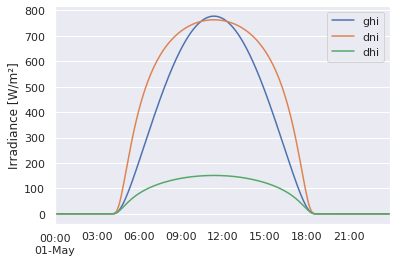

In [2]:
lat, lon = 50.1109, 8.6821

location = pvlib.location.Location(lat, lon)
df = location.get_clearsky(pd.date_range("2020-01-01", "2020-12-31", freq="5min"))

df.loc["2020-05-01"].plot()
plt.ylabel("Irradiance [W/m²]")

Text(0, 0.5, 'Sun angles [°]')

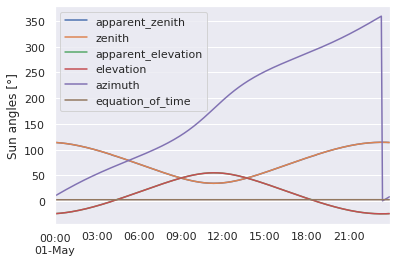

In [3]:
df2 = location.get_solarposition(df.index)

df2.loc["2020-05-01"].plot()
plt.ylabel("Sun angles [°]")

Global Horizontal (GHI) = Direct Normal (DNI) X cos(θ) + Diffuse Horizontal (DHI)

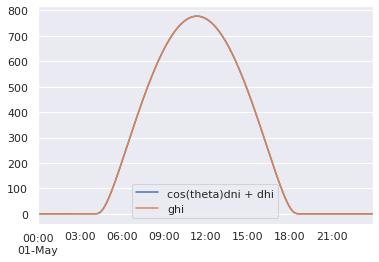

In [4]:
df3 = df.join(df2)
df3["zenith"] = np.radians(df3.zenith)

(np.cos(df3.zenith) * df3.dni + df3.dhi).loc["2020-05-01"].plot(label="cos(theta)dni + dhi")
df3.loc["2020-05-01"].ghi.plot()
plt.legend()

## Horizon line

Text(0.5, 1.0, 'Sun elevation above generated horizon line on 2020-05-01')

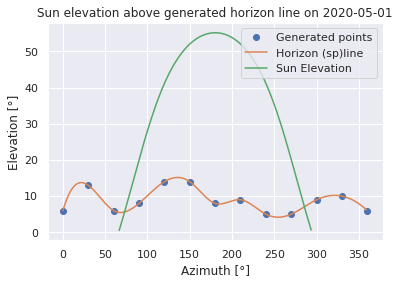

In [5]:
import scipy
from scipy import interpolate

x = np.arange(0, 361, 30)
y = np.random.randint(5,15, len(x)-1)
y = np.append(y, y[0])

tck = interpolate.splrep(x, y, s=0)

azimuth = np.arange(0,360) 

elevation = interpolate.splev(azimuth, tck, der=0)

plt.plot(x,y, 'o', label="Generated points")
plt.plot(azimuth, elevation, label="Horizon (sp)line")


azi = df3[df3.elevation>0].loc["2020-05-01"].azimuth.values
ele = df3[df3.elevation>0].loc["2020-05-01"].elevation.values
plt.plot(azi, ele, label="Sun Elevation")

plt.legend()
plt.xlabel("Azimuth [°]")
plt.ylabel("Elevation [°]")
plt.title("Sun elevation above generated horizon line on 2020-05-01")

## Effect of horizon shading on irradiance

/home/dutchman/miniconda3.1/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/dutchman/miniconda3.1/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/dutchman/miniconda3.1/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/dutchman/miniconda3.1/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/dutchman/miniconda3.1/lib/python3.7/_collections_abc.py:841: Matpl

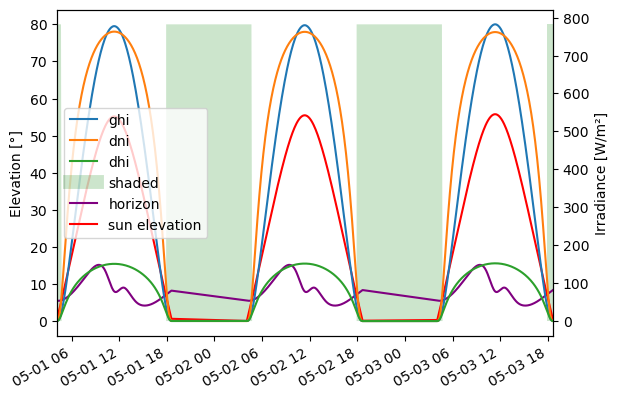

In [6]:
sns.reset_orig()

df3["horizon"] = interpolate.splev(df3.azimuth, tck, der=0)
df3["shaded"] = (df3.elevation < interpolate.splev(df3.azimuth, tck, der=0))

tmp = df3[df3.elevation>0].loc["2020-05-01":"2020-05-03"]


ax = tmp.horizon.plot(color="purple")
tmp.elevation.plot(ax=ax, color="red")
plt.fill_between(tmp.index, 0, 80, facecolor='green', interpolate=True, alpha=.2, where=tmp.shaded)

ax2 = ax.twinx()
tmp.ghi.plot(ax=ax2)
tmp.dni.plot(ax=ax2)
tmp.dhi.plot(ax=ax2)



plt.plot([],[], color="green", alpha=.2, linewidth=10, label="shaded")
plt.plot([], [], color="purple", label="horizon")
plt.plot([], [], color="red", label="sun elevation")

plt.legend()

ax.set_ylabel("Elevation [°]")
ax2.set_ylabel("Irradiance [W/m²]")

sns.set()

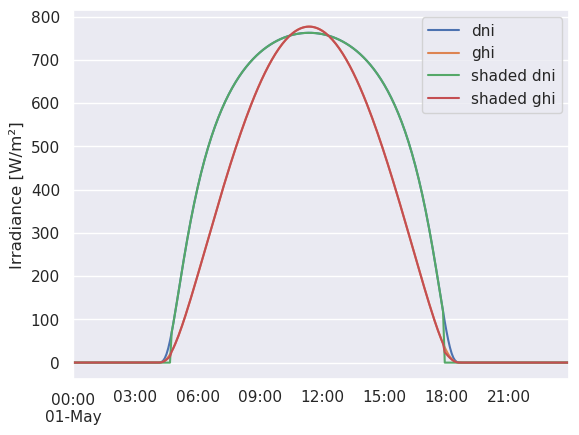

In [8]:
df3["shaded dni"] = df3.dni
df3.loc[df3.shaded, "shaded dni"] = 0

df3["shaded ghi"] = (np.cos(df3.zenith) * df3["shaded dni"] + df3.dhi)

df3.loc["2020-05-01"]["dni"].plot()
df3.loc["2020-05-01"]["ghi"].plot()
df3.loc["2020-05-01"]["shaded dni"].plot()
df3.loc["2020-05-01"]["shaded ghi"].plot()

plt.ylabel("Irradiance [W/m²]")
plt.legend()

In [9]:
def horizon_shading(horizon):
    tmp = df3.copy()
    tmp["horizon"] = interpolate.splev(tmp.azimuth, horizon, der=0)
    tmp["shaded"] = (tmp.elevation < tmp["horizon"])
    tmp["shaded dni"] = df3.dni
    tmp.loc[tmp.shaded, "shaded dni"] = 0

    retval = (np.cos(tmp.zenith) * tmp["shaded dni"] + tmp.dhi)
    return retval

def plot_horizon(horizon):
    tmp = df3.loc["2020-06-20"].copy()
    tmp["horizon"] = interpolate.splev(tmp.azimuth, horizon, der=0)
    tmp = tmp.reset_index().set_index("azimuth")
    return tmp[tmp.elevation>0].horizon

def arr2spl(arr):
    retval = interpolate.splrep(np.arange(0, 361, 30), arr, s=0)
    return retval

## Find horizon through optimization (PSO)

In [22]:
x = np.arange(0, 361, 30)
y = np.random.randint(5,15, len(x)-1)
y = np.append(y, y[0])

hor1 = interpolate.splrep(x, y, s=0)

rmsd = lambda x,y : np.sqrt(((x-y)**2).mean())
rmsd(horizon_shading(hor1), df3["shaded ghi"])

10.930363623056758

In [23]:
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms.utils.plotters
ps.__version__

dim = 13

def f(x):
    nofpart, dim = x.shape
    horz = [interpolate.splrep(np.arange(0, 361, 30), x[ix, :], s=0) for ix in range(nofpart)]
    retval = np.array([rmsd(horizon_shading(hor), df3["shaded ghi"]) for hor in horz])
    return retval

# instatiate the optimizer
x_max = 20 * np.ones(dim)
x_min = np.zeros(dim)
bounds = (x_min, x_max)
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=10, dimensions=13, options=options, bounds=bounds)

# now run the optimization, pass a=1 and b=100 as a tuple assigned to args

cost, pos = optimizer.optimize(f, 10)

2020-02-09 15:11:01,715 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=4.64
2020-02-09 15:11:03,422 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4.6403849414042595, best pos: [ 8.43867229  2.93902066  6.82379407 10.08476952 14.503443   13.48610012
  5.12998197  3.72596523  3.92944299  7.78935441 11.92929701 15.87084462
  7.52852427]


In [24]:
pso = lambda nofp : GlobalBestPSO(n_particles=nofp, dimensions=13, options=options, bounds=bounds).optimize(f, 100)[1]

pso_results = [pso(nofp) for nofp in range(1, 10)]

2020-02-09 15:11:06,961 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=19.6
2020-02-09 15:11:09,051 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 19.55746665801809, best pos: [ 3.151263   11.11300978  6.85477973  6.90740275 13.72407973  1.73504483
 18.1426372  11.71801787  4.06527717 14.21310897  8.39541648 16.43824515
 13.83571108]
2020-02-09 15:11:09,057 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=5.19
2020-02-09 15:11:13,074 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5.186478759176011, best pos: [ 4.04605664  4.33647505  2.91774601  9.0227123  11.46734996 14.57605314
  2.01023754  4.13090782  8.10853405  5.1910965   2.61871036 12.56086395
  5.11383067]
2020-02-09 15:11:13,083 - pyswarms.singl

Text(0.5, 1.0, 'Approxing the horizon line with increasing number of particles')

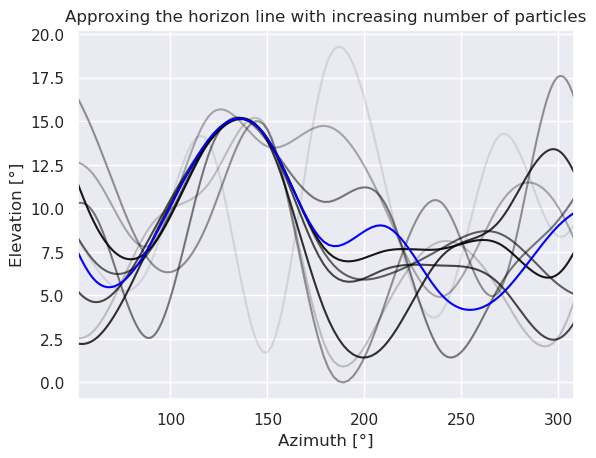

In [25]:
for ix in range(len(pso_results)):
    plot_horizon(arr2spl(pso_results[ix])).plot(alpha = ix/10 + .1, color="black")

plot_horizon(tck).plot(color="blue")
plt.ylabel("Elevation [°]")
plt.xlabel("Azimuth [°]")
plt.title("Approxing the horizon line with increasing number of particles")

## Real horizon data

From www.webservice-energy.org, run by www.mines-paristech.fr.

I multiply the horizon by 10 to make things more interesting. =D

Text(0, 0.5, 'Elevation [°]')

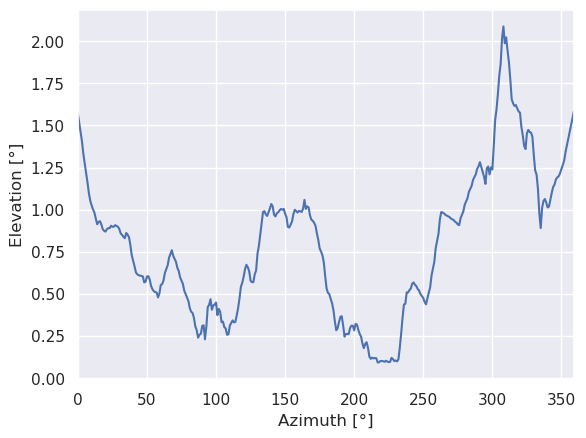

In [12]:
import requests
import io

url = 'http://toolbox.webservice-energy.org/service/wps/'

coords = 'latitude=%f;longitude=%f;altitude=%f'% (lat, lon, -999)

params = {
             'service':       'WPS',
             'request':       'Execute',
             'identifier':    'compute_horizon_srtm',
             'version':       '1.0.0',
             'DataInputs':    coords,
             'RawDataOutput': 'result'
             }
response = requests.get(url, params=params)
string = io.StringIO(response.text)
horizon = pd.read_csv(string, sep=';', comment='#', header=None,
                     names=['azimuth', 'elevation'])

horizon.set_index('azimuth')["elevation"].plot()
plt.xlabel("Azimuth [°]")
plt.ylabel("Elevation [°]")

In [13]:
gthor = interpolate.splrep(np.arange(0, 360, 1), horizon['elevation'].values * 10, s=0)
gtghi = horizon_shading(gthor)

step = 10
dim = int(360 / step)

def f(x):
    nofpart, dim = x.shape
    horz = [interpolate.splrep(np.arange(0, 360, step), x[ix, :], s=0) for ix in range(nofpart)]
    retval = np.array([rmsd(horizon_shading(hor), gtghi) for hor in horz])
    return retval

# instatiate the optimizer
x_max = 20 * np.ones(dim)
x_min = np.zeros(dim)
bounds = (x_min, x_max)
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=50, dimensions=dim, options=options, bounds=bounds)

cost, pos = optimizer.optimize(f, 100)

2020-02-09 14:49:17,085 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=2.43
2020-02-09 14:50:46,557 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.4278113952878035, best pos: [13.70607116  6.32924713 10.82501565  3.9089264  14.18884422 15.99540684
 11.45472134  0.20795806  2.76276666  5.78979854  9.49231314  6.71308177
  8.69590575  7.29603375 10.2777272   6.2837661   9.019972   14.03086207
 11.71472364  7.99140912 11.7681298   9.21107496  5.50567851  6.20255174
  4.98174957  3.79742494  8.22176383  9.42669631  9.91562835 12.83450691
  8.5659423   8.62543483 11.74667913 16.27597355  6.74007014  6.09665106]


Text(0, 0.5, 'Elevation [°]')

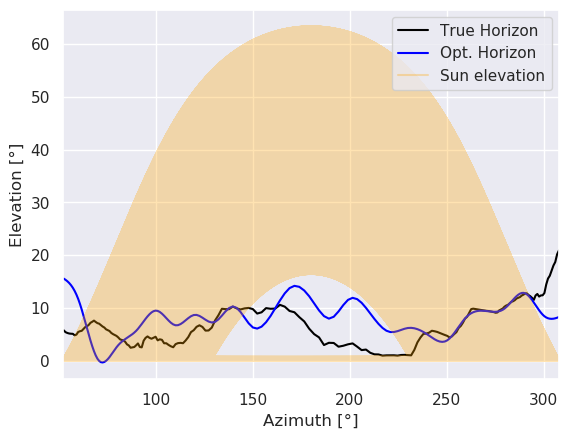

In [14]:
ax = (plot_horizon(gthor)).plot(color="black", label="True Horizon")

pos_tmp = interpolate.splrep(np.arange(0, 360, step), pos, s=0)
(plot_horizon(pos_tmp)).plot(color="blue", ax=ax,label="Opt. Horizon")

tmp = df3.set_index('azimuth').elevation
tmp[tmp>0].plot(color="orange", alpha=.3, label="Sun elevation", ax=ax)

plt.legend()
plt.xlabel("Azimuth [°]")
plt.ylabel("Elevation [°]")

Text(0.5, 1.0, 'Horizon loss with 36 interpolation points and 50 particles')

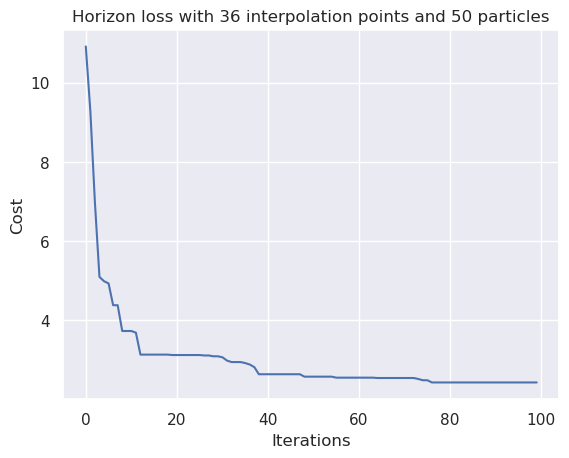

In [15]:
hist = optimizer.cost_history
plt.plot(hist)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.title("Horizon loss with 36 interpolation points and 50 particles")

## Find best optimization setting

In [17]:
gthor = interpolate.splrep(np.arange(0, 360, 1), horizon['elevation'].values * 10, s=0)
gtghi = horizon_shading(gthor)

def hyper_opt(step=10, nofp=10, iterations=100):
    dim = int(360 / step)

    def f(x):
        nofpart, dim = x.shape
        horz = [interpolate.splrep(np.arange(0, 360, step), x[ix, :], s=0) for ix in range(nofpart)]
        retval = np.array([rmsd(horizon_shading(hor), gtghi) for hor in horz])
        return retval

    # instatiate the optimizer
    x_max = 20 * np.ones(dim)
    x_min = np.zeros(dim)
    bounds = (x_min, x_max)
    options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
    optimizer = GlobalBestPSO(n_particles=nofp, dimensions=dim, options=options, bounds=bounds)

    cost, pos = optimizer.optimize(f, iterations)
    return optimizer.cost_history

def hyperdf(step, nofp, iterations=100):
    tmpdf = pd.DataFrame()
    tmpdf["Cost"] = hyper_opt(step, nofp, iterations)
    tmpdf["Points"] = step
    tmpdf["Particles"] = nofp
    tmpdf["Iterations"] = [i for i in range(iterations)]
    
    return tmpdf

In [18]:
optdf = pd.DataFrame()

for step in [30, 20, 10, 5, 1]:
    for nofp in [5, 10, 15, 20, 25, 30]:
        optdf = pd.concat([optdf, hyperdf(step, nofp)])

optdf.head()

2020-02-09 14:52:40,489 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.37
2020-02-09 14:52:49,092 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.366720779827011, best pos: [14.73211059  9.9664334  10.07776809  5.43903769  8.09126046 10.4757176
 15.05133525  6.96062256  8.54167262  8.53061905 11.51267277  7.20484645]
2020-02-09 14:52:49,100 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.24
2020-02-09 14:53:05,745 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.235929020958488, best pos: [ 7.69637934 13.97035669  6.69123261  5.02663842  9.5916038   8.03707536
  9.12630153  7.5614237   4.08708973  9.5197537  12.6465619  10.51891397]
2020-02-09 14:53:05,760 - pyswarms.single.global_best - INFO - Opti

2020-02-09 14:59:19,792 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.07
2020-02-09 14:59:52,280 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.0698676854945894, best pos: [15.23990572  6.08536503  8.934386   10.85900059 11.05583877 13.93097527
 10.3505783   4.40895961  8.75805171 11.08574788  7.66047566  9.9164289
  7.0914822   7.17072064  8.81980241  9.46328349  5.75400117 13.67702551
  2.72820114  7.85057597  6.61684728  9.09933182  3.91066807  8.13829967
  4.73674426  4.90785824  8.081382   11.21657933  9.16331429 12.91015632
  7.75234512  9.4617845   4.0054002  15.64131808  7.92245716 12.18862936]
2020-02-09 14:59:52,295 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=2.75
2020-02-09 15:00:34,639 - pyswarms.single.global

2020-02-09 15:03:34,995 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.54
2020-02-09 15:04:26,629 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.5448420749770824, best pos: [ 6.70247116  5.69980257  5.15687976  6.73974949 12.96438753 16.70509529
  6.63498086 13.60908663 10.12301466 13.0067559   5.34099322 10.45382868
  4.34325612  7.11371804  6.62386542 10.07689914  6.92826832  3.89670243
 11.49362736  6.27421584  4.62231097  9.65369344  7.91455146  7.53856359
 10.21548698  3.21218614  1.89481186  6.33790642 10.463952    9.92523456
  9.26431567  4.56161963  5.94009217  8.12706807 10.99979572 11.57479677
  3.84724868  6.41995246  7.88333791 12.31124348  7.64713917  8.66166647
  5.90346504  5.60422602  4.30599314  7.72032713  8.11238638  9.21109027
  8.83424851  7.85036297  9.62518266  6.32667382  9.51840562 10.41970898
  9.32043255  8.604856

2020-02-09 15:04:56,401 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=7.02
2020-02-09 15:05:23,322 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.02012540308844, best pos: [ 9.08742689 10.47361779 10.31656164 11.93275122 13.21665621 14.09027152
 15.33516719 10.86483122 14.96809688 14.53107786  7.63034428 10.30590632
  9.94769591 13.2251447  10.65905727 11.42703391 10.50325975 11.75298303
 14.72494205  8.63291907  9.79420146  5.62358335  8.03845597 10.47977798
 14.3553729   9.55264478 11.25105251 12.61997474 12.63882283 14.6356102
 12.86465026 14.48728316 12.49903459 11.58311078 11.92816691  6.40410606
  8.75866351  8.70309638 13.46661245  7.17613039  4.57109698  9.8277683
  9.45248065  9.75068586 13.40097756  6.64096465  3.82286473 13.56841988
  7.88276733 14.85773249 13.99914909  5.41719727 10.44003851  9.25779128
 10.15116779 12.54157641 1

2020-02-09 15:05:56,477 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=7.47
2020-02-09 15:06:43,784 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.474176865156332, best pos: [18.46075391 13.19167726 13.20416378 13.57217658 13.14578305  8.18333799
  6.96350931 14.75219347 15.87602387  7.17030301  7.66068298  3.79246277
 12.28814497 12.13609722  8.50850757 10.52041914  9.15413366  9.83822834
 12.2205354  13.38236304  6.9929176   8.12544024  9.66255992 10.97506292
  9.5462133   8.74397177  7.60741789 12.02108634  7.56782452  9.59113069
 11.70870753 15.40004055  8.19966267  9.04801198 15.42987134  4.98277787
  7.73423926 11.58976241  8.9279809  14.81313259  9.71171141 17.0592865
  8.36913523 19.09664806 10.09350933 11.93980087 14.79484949 15.52611791
  9.31470003  7.77362153 10.00386856 11.26442797 14.55122226  4.98715467
  5.4657412  15.29990356

,Cost,Points,Particles,Iterations
0,13.353304,30,5,0
1,12.781709,30,5,1
2,12.006905,30,5,2
3,10.323046,30,5,3
4,10.323046,30,5,4


Text(0.5, 0, 'Points per 360')

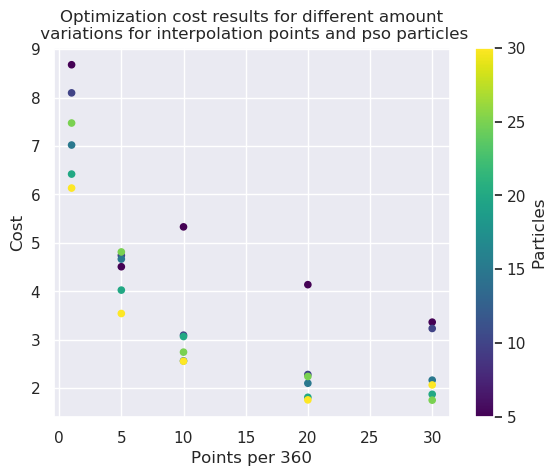

In [31]:
optdf.query("Iterations == 99").plot.scatter(x="Points", y="Cost", c="Particles", colormap='viridis')
plt.title("Optimization cost results for different amount\n variations for interpolation points and pso particles")
plt.xlabel("Points per 360")